# MNIST image classification with Keras Tensorflow backend

In [1]:
import os
import shutil
from datetime import datetime
import sys
import json
import argparse

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

2.1.0


In [2]:
PROJECT = "ml-practice-260405" # REPLACE WITH YOUR PROJECT ID
BUCKET = "bucket-ml-practice-260405" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE = "dnn"  # "linear", "dnn", "dnn_dropout", or "cnn"

In [3]:
# Do not change 
os.environ["ACCOUNT"] = "sandcorp2014@gmail.com"
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "1.13"  # Tensorflow version

In [4]:
%%bash
gcloud config set account $ACCOUNT

Updated property [core/account].


In [5]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


In [ ]:
%%bash
mkdir mnistmodel_keras_tf
mkdir mnistmodel_keras_tf/trainer/

In [6]:
%%writefile mnistmodel_keras_tf/trainer/__init__.py
##

Overwriting mnistmodel_keras_tf/trainer/__init__.py


In [7]:
%%writefile mnistmodel_keras_tf/trainer/task.py
import argparse
import json
import os

from .import model
import tensorflow as tf

if __name__ == '__main__':
    # Create a parser object
    parser = argparse.ArgumentParser()
    
    # Input argument in the parser object
    parser.add_argument(
        "--train_batch_size",
        help="Batch size for training",
        type = int,
        default=100
    )
    
    parser.add_argument(
        "--learning_rate",
        help="Initial Learning Rate For Training",
        type=float,
        default=0.01
    )
    
    parser.add_argument(
        "--train_steps",
        help="Steps to run the training jobs for",
        type=int,
        default=0
    )
    
    parser.add_argument(
        "--output_dir",
        help="Local Or GCS location to write checkpoint and export model",
        required=True
    )
    
    parser.add_argument(
        "--job-dir",
        help = "this model ignores this field, but it is required by gcloud",
        default = "junk"
    )
    
    args = parser.parse_args()
    hparams = args.__dict__

    # unused args provided by service
    hparams.pop("job_dir", None)
    hparams.pop("job-dir", None)

    output_dir = hparams.pop("output_dir")
    # Append trial_id to path so hptuning jobs don"t overwrite eachother
    output_dir = os.path.join(
        output_dir,
        json.loads(
            os.environ.get("TF_CONFIG", "{}")
        ).get("task", {}).get("trial", "")
    )
    
    # Run the training job
    model.train_and_evaluate(output_dir, hparams)

Overwriting mnistmodel_keras_tf/trainer/task.py


In [8]:
%%writefile mnistmodel_keras_tf/trainer/model.py
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

HEIGHT=28
WIDTH=28
NCLASSES=10

# Build Keras model using Keras Sequential API
def dnn_model(hparams):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=[HEIGHT, WIDTH, 1], name="image"))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=300, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(units=100, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(units=30, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(units=NCLASSES, activation=tf.nn.softmax, name='Probabilities'))
    return model

# Create serving input function for inference
def serving_input_fn():
    # Input will be rank 3
    feature_placeholders = {
        "image": tf.compat.v1.placeholder(dtype = tf.float32, shape=[None, HEIGHT, WIDTH])
    }
    # But model function require rank 4
    features = {
        "image": tf.expand_dims(input=feature_placeholders["image"], axis=-1)
    }
    return tf.estimator.export.ServingInputReceiver(
        features=features,
        receiver_tensors=feature_placeholders
    )

# Create train and evaluate function
def train_and_evaluate(ouput_dir, hparams):
    # Ensure filewriter cache is clear for TensorBoard event file.
    tf.compat.v1.summary.FileWriterCache.clear()
    
    EVAL_INTERVAL = 60
    
    # Get mnist Data
    mnist = tf.keras.datasets.mnist
    
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Scale our training and testing features between 0 and 1
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    # Reshape image to add a dimension for channels (1 in this case)
    x_train = x_train.reshape([-1, HEIGHT, WIDTH, 1])
    x_test = x_test.reshape([-1, HEIGHT, WIDTH, 1])
    
    # Convert labels to categorical one hot encoding
    y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=NCLASSES)
    y_test = tf.keras.utils.to_categorical(y=y_test, num_classes=NCLASSES)
    
    # Create training input function
    train_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
        x={"image": x_train},
        y=y_train,
        batch_size=100,
        num_epochs=None,
        shuffle=True,
        queue_capacity=5000
    )
    
    # Create evaluation input function
    eval_input_fn = tf.compat.v1.estimator.inputs.numpy_input_fn(
        x={"image": x_test},
        y=y_test,
        batch_size=100,
        num_epochs=1,
        shuffle=False,
        queue_capacity=5000
    )
    
    # Build Keras model
    model = dnn_model(hparams=hparams)
    
    # Compile Keras model with optimizer, loss function and eval metric
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Convert Keras model to estimator
    estimator = tf.keras.estimator.model_to_estimator(
        keras_model=model,
        model_dir=ouput_dir,
        config=tf.estimator.RunConfig(save_checkpoints_secs=EVAL_INTERVAL)
    )
    
    # Set estimator's train_spec to use train_input_fn() and train for so many steps
    train_spec = tf.estimator.TrainSpec(
        input_fn=train_input_fn,
        max_steps=hparams['train_steps']
    )
    
    # Create exporter that use serving_input_fn() to create saved_model for serving
    exporter = tf.estimator.LatestExporter(
        name='exporter',
        serving_input_receiver_fn=serving_input_fn
    )
    
    # Set estimators eval_spec to use eval_input_fn() and export saved_model
    eval_spec = tf.estimator.EvalSpec(
        input_fn=eval_input_fn,
        steps=None,
        exporters=exporter,
        throttle_secs=EVAL_INTERVAL
    )
    
    # Run train_and_evaluate loop
    tf.estimator.train_and_evaluate(
        estimator=estimator,
        train_spec=train_spec,
        eval_spec=eval_spec
    )

Overwriting mnistmodel_keras_tf/trainer/model.py


## Run as a Python module

Since we want to run our code on Cloud ML Engine, we've packaged it as a python module.

The `model.py` and `task.py` containing the model code is in <a href="mnistmodel_keras_tf/trainer">mnistmodel_keras_tf/trainer</a>

**Let's first run it locally for a few steps to test the code.** 

In [20]:
%%bash
rm -rf mnistmodel_keras_tf.tar.gz mnist_keras_tf_trained
JOB_DIR=./tmp
gcloud ml-engine local train \
    --module-name=trainer.task \
    --package-path=./mnistmodel_keras_tf/trainer \
    --job-dir=JOB_DIR \
    -- \
    --output_dir=./mnist_keras_tf_trained \
    --train_steps=100 \
    --learning_rate=0.01

2020-06-23 11:38:38.694087: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2020-06-23 11:38:38.694149: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2020-06-23 11:38:38.694157: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
W0623 11:38:39.775887 140009068603200 module_wrapper.py:138] From /media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/08.Image Understanding with TensorFlow on GCP/Week_1/Lab_2_Image_Classification_with_a_Deep_Neural_Network_Model/Practice/mnistmodel_keras_tf

<b><p style='color:red'>Loss for final step: 0.23213314</p></b>

Run as python module.

In [21]:
%%bash
rm -rf mnistmodel_keras_tf.tar.gz mnist_keras_tf_trained
python3 -m mnistmodel_keras_tf.trainer.task \
    --learning_rate=0.01 \
    --train_steps=100 \
    --output_dir=./mnist_keras_tf_trained

2020-06-23 11:38:53.639599: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory
2020-06-23 11:38:53.639663: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory
2020-06-23 11:38:53.639669: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
W0623 11:38:55.200824 139890367465280 module_wrapper.py:138] From /media/mujahid7292/Data/GoogleDriveSandCorp2014/ML_With_TensorFlow_On_GCP/08.Image Understanding with TensorFlow on GCP/Week_1/Lab_2_Image_Classification_with_a_Deep_Neural_Network_Model/Practice/mnistmodel_keras_tf

<b><p style='color:red'>Loss for final step: 0.2467457</p></b>

**Now, let's do it on Cloud ML Engine so we can train on GPU (`--scale-tier=BASIC_GPU`)**

Note the GPU speed up depends on the model type. You'll notice the more complex CNN model trains significantly faster on GPU, however the speed up on the simpler models is not as pronounced.

In [12]:
%%bash
OUTDIR=gs://${BUCKET}/mnist/trained_dnn
JOBNAME=mnist_dnn_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
    --region=$REGION \
    --module-name=trainer.task \
    --package-path=./mnistmodel_keras_tf/trainer \
    --job-dir=$OUTDIR \
    --staging-bucket=gs://$BUCKET \
    --scale-tier=BASIC_GPU \
    --runtime-version=$TFVERSION \
    -- \
    --output_dir=$OUTDIR \
    --train_steps=100 \
    --learning_rate=0.01 \
    --train_batch_size=512 

gs://bucket-ml-practice-260405/mnist/trained_dnn us-central1 mnist_dnn_200623_043818
jobId: mnist_dnn_200623_043818
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [mnist_dnn_200623_043818] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mnist_dnn_200623_043818

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mnist_dnn_200623_043818


<b><p style='color:red'>Loss for final step: 0.19776809</p></b>

## Deploying and predicting with model

Deploy the model:

In [13]:
%%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained_${MODEL_TYPE}/export/exporter | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

Deleting and deploying mnist dnn from gs://bucket-ml-practice-260405/mnist/trained_dnn/export/exporter/1592887244/ ... this will take a few minutes


INFO 0623 10:50:57.387782 retry_util.py] Retrying request, attempt #1...
Created ml engine model [projects/ml-practice-260405/models/mnist].
Creating version (this might take a few minutes)......
........................................................................................done.


To predict with the model, let's take one of the example images.

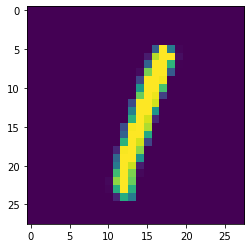

In [14]:
import json, codecs
import matplotlib.pyplot as plt
import tensorflow as tf

HEIGHT = 28
WIDTH = 28

# Get mnist data
mnist = tf.keras.datasets.mnist

(_, _), (x_test, _) = mnist.load_data()

# Scale our features between 0 and 1
x_test = x_test / 255.0 

IMGNO = 5 # CHANGE THIS to get different images
jsondata = {"image": x_test[IMGNO].reshape(HEIGHT, WIDTH).tolist()}
json.dump(jsondata, codecs.open("test.json", 'w', encoding = "utf-8"))
plt.imshow(x_test[IMGNO].reshape(HEIGHT, WIDTH));

Send it to the prediction service

In [16]:
%%bash
gcloud ai-platform predict \
    --model=mnist \
    --version=${MODEL_TYPE} \
    --json-instances=./test.json

PROBABILITIES
[1.8366279618931003e-05, 0.9959606528282166, 0.0004146232095081359, 5.972717553959228e-05, 3.9062806536094286e-06, 0.000798432738520205, 7.479923078790307e-05, 0.001814400078728795, 0.000790452235378325, 6.461288285208866e-05]


## Remove Trained Directory

In [19]:
%%bash
rm -rf mnistmodel_keras_tf.tar.gz mnist_keras_tf_trained